In [1]:

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import uuid
import string

from matplotlib import animation, rc
from IPython.display import HTML, Image
from collections import defaultdict

import altair as alt
alt.renderers.enable('notebook')

rc('animation', html='html5')
plt.ioff()

In [2]:
def process(graph):
    for node in graph.node:
        if 'cost' not in graph.node[node]:
            graph.node[node]['cost'] = 1 + int(random.random() * 10)
            
    root = random.choice([n for n in graph.node if graph.in_degree[n] == 0])
        
    for node in graph.node:
        ancestors = nx.ancestors(graph, node)
        cost = graph.node[node]['cost']
        in_deg = graph.in_degree[node]
        parents = set()
        for ancestor in ancestors:
            cost += graph.node[ancestor]['cost']
            parents.add(ancestor)
        graph.node[node]['true_cost'] = cost
        graph.node[node]['depth'] = len(nx.ancestors(graph, node))
        graph.node[node]['parents'] = parents

In [182]:
def dep_list(graph):
    depth_nodes = defaultdict(list)

    for node in graph.nodes():
        num_ancestors = len(nx.ancestors(graph, node))
        depth_nodes[num_ancestors].append(node)

    dependency_list = []
    for depth in sorted(depth_nodes.keys()):
        dependency_list.append(depth_nodes[depth])

    return dependency_list

def get_positions(deps):
    positions = {}

    longest = max([len(row) for row in deps])
    total = sum([len(row) for row in deps])

    for i, row in enumerate(deps):
        for j, node in enumerate(row):
            row_count = len(row)
            y_pos = (float(j+1) / (row_count+1)) * longest + (0.2 - random.random() * 0.4)
            positions[node] = [i, y_pos]
    
    return positions

In [484]:
class GraphTraversal(object):
    def __init__(self, graph, graph_id, ax=None, max_ticks=None):
        self.graph = graph
        self.ax = ax
        
        self.color_map = {n: '#cccccc' for n in graph.node}
        self.node_progress = {}
        
        #self.pos = graphviz_layout(self.graph, prog='dot', args='-Grankdir="LR" -Granksep="10" ')
        self.pos = get_positions(dep_list(self.graph))
        
        self.max_ticks = max_ticks

        self.num_completed_nodes = 0
        self.completed_at = None
        
        self.ticks = []
        self.graph_id = graph_id
        
        self.nodes_to_process = set()
        self.completed_nodes = set()
        
    def stats(self):
        costs = [self.prop(n, 'cost') for n in self.graph.node]
        depths = [self.prop(n, 'depth') for n in self.graph.node]
        return {
            "num_nodes": len(self.graph.node),
            "graph_id": self.graph_id,
            "costs": costs,
            "runtime": self.completed_at,
            "depths": depths
        }

    def colors(self):
        return "#8CCCF0"
    
    def sizes(self):
        return [self.prop(n, 'cost') * 50 for n in self.graph.node]
    
    def node(self, node_name):
        return self.graph.node[node_name]
    
    def prop(self, node_name, prop):
        return self.graph.node[node_name][prop]
    
    def in_progress(self, node_name):
        self.color_map[node_name] = '#FFE66D'
        self.node_progress[node_name] = 0
        
    def node_complete(self, node_name):
        self.color_map[node_name] = '#5fb825'
        self.nodes_to_process.remove(node_name)
        self.num_completed_nodes += 1
        
    def build_complete(self, i):
        if not self.completed_at:
            self.completed_at = i
            
    def title(self, tick_no):
        return ""
    
    def labels(self):
        nodes = nx.dfs_tree(random_graph, source='node_0').nodes
        import string
        res = {}
        for i, n in enumerate(nodes):
            res[n] = string.ascii_uppercase[i]
        return res
        
    def render(self, i):
        self.ticks.append(self.num_completed_nodes)
        
        if self.max_ticks and i > self.max_ticks:
            return
        
        tick_no = i
        if self.completed_at is not None:
            tick_no = self.completed_at
            
        if not self.ax:
            return
        
        self.ax.clear()
        nx.draw(self.graph,
                pos=self.pos,
                node_size=1000,
                node_color=self.colors(),
                arrows=True,
                node_shape="o",
                edge_color="#cccccc",
                font_size=12,
                labels=self.labels(),
                arrowsize=20,
                with_labels=True,
                ax=self.ax)
        self.ax.set_title(self.title(tick_no))
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        
class TopologicalSortedGraphTraversal(GraphTraversal):
    name = "Topolgical"
    def __init__(self, graph, graph_id, ax=None, max_ticks=None):
        super(TopologicalSortedGraphTraversal, self).__init__(graph, graph_id, ax, max_ticks)
        self.pos = self.get_positions(dep_list(self.graph))
        self.sorted = list(nx.topological_sort(self.graph))
        self.index = 0
        
    def get_positions(self, *args, **kwargs):
        order = nx.topological_sort(self.graph)
        positions = {}

        for i, node in enumerate(order):
            positions[node] = [i, 1]

        return positions

    def update(self, i):
        if self.index >= len(self.sorted):
            return True
        
        node = self.sorted[self.index]
        
        if node not in self.node_progress:
            self.in_progress(node)
            self.nodes_to_process.add(node)

        if i > 0:
            for node in list(self.nodes_to_process):
                self.node_progress[node] += 1
                if self.node_progress[node] >= self.prop(node, 'cost'):
                    self.node_complete(node)
                    self.completed_nodes.add(node)
                    
        self.render(i)
        
        if self.num_completed_nodes == len(self.graph.node):
            self.build_complete(i)
            return True
    
class DepthAwareGraphTraversal(GraphTraversal):
    def __init__(self, graph, graph_id, ax=None, max_ticks=None):
        super(DepthAwareGraphTraversal, self).__init__(graph, graph_id, ax, max_ticks)
    
    def labels(self):
        nodes = nx.dfs_tree(random_graph, source='node_0').nodes
        import string
        res = {}
        for i, n in enumerate(nodes):
            res[n] = "{} ({})".format(string.ascii_uppercase[i], self.prop(n, 'depth'))
        return res

class CostAwareGraphTraversal(GraphTraversal):
    def __init__(self, graph, graph_id, ax=None, max_ticks=None):
        super(CostAwareGraphTraversal, self).__init__(graph, graph_id, ax, max_ticks)
        
    def title(self, tick_no):
        return "Time={}".format(tick_no)
    
    def labels(self):
        nodes = nx.dfs_tree(random_graph, source='node_0').nodes
        import string
        res = {}
        for i, n in enumerate(nodes):
            res[n] = "{} ({})".format(string.ascii_uppercase[i], self.prop(n, 'cost'))
        return res
    
    def colors(self):
        colors = []
        for node in self.graph.node:
            colors.append(self.color_map[node])
            
        return colors

THREADS = 4
    
class NaiveGraphTraversal(CostAwareGraphTraversal):
    name = "Run Level"
    def __init__(self, graph, graph_id, ax=None, max_ticks=None):
        super(NaiveGraphTraversal, self).__init__(graph, graph_id, ax, max_ticks)
        
        self.max_degrees = 0

    def update(self, i):
        if len(self.nodes_to_process) == 0:
            self.nodes_to_process = set()
            for n in self.graph.node:
                if self.prop(n, 'depth') == self.max_degrees:
                    self.nodes_to_process.add(n)
            
            self.max_degrees += 1

            for node in self.nodes_to_process:
                self.in_progress(node)

        if i > 0:
            for j, node in enumerate(list(self.nodes_to_process)):
                if j < THREADS:
                    self.node_progress[node] += 1
                    if self.node_progress[node] > self.prop(node, 'cost'):
                        self.node_complete(node)
                    
        self.render(i)
        
        if self.num_completed_nodes == len(self.graph.node):
            self.build_complete(i)
            return True
        return False
        

class SmartGraphTraversal(CostAwareGraphTraversal):
    name = "Priority Queue"
    def __init__(self, graph, graph_id, ax=None, max_ticks=None):
        super(SmartGraphTraversal, self).__init__(graph, graph_id, ax, max_ticks)
        
    def can_run_node(self, node_name):
        ancestors = self.prop(node_name, 'parents')
        remaining_ancestors = len(ancestors.difference(self.completed_nodes))
        return remaining_ancestors == 0 and node_name not in self.completed_nodes

    def update(self, i):
        all_nodes_to_process = {n for n in self.graph.node if self.can_run_node(n)}
        new_nodes_to_process = all_nodes_to_process.difference(self.nodes_to_process)

        for i, node in enumerate(new_nodes_to_process):
            self.in_progress(node)
            self.nodes_to_process.add(node)

        if i > 0:
            for j, node in enumerate(list(self.nodes_to_process)):
                if j < THREADS:
                    self.node_progress[node] += 1
                    if self.node_progress[node] > self.prop(node, 'cost'):
                        self.node_complete(node)
                        self.completed_nodes.add(node)
                    
        self.render(i)
        
        if self.num_completed_nodes == len(self.graph.node):
            self.build_complete(i)
            return True
        return False

In [352]:


def render(graph, step_ms=200, algos=None):
    process(graph)
    graph_id = str(uuid.uuid4())
    
    fig, axes = plt.subplots(len(algos), 1, figsize=(18, 5 * len(algos)), sharex=True)
    if len(algos) == 1:
        axes = [axes]
    
    algo_instances = []
    for ax, algoClass in zip(axes, algos):
        new_algo = algoClass(graph, graph_id, ax)
        algo_instances.append(new_algo)
    
    animation_complete = {"done": False}

    def update(i):
        statuses = [algo.update(i) for algo in algo_instances]
        if all(statuses):
            animation_complete['done'] = True
            
    def frames():
        i = 0
        while not animation_complete['done']:
            yield i
            i += 1

    animation = matplotlib.animation.FuncAnimation(fig, update, frames=frames, interval=step_ms, repeat=False)
    return {
        "animation": animation,
        "algos": {algo.name: algo for algo in algo_instances}
    }

def render_once(graph, ax, algoClass=None):
    if algoClass is None:
        algoClass = GraphTraversal
        
    process(graph)

    graph_id = str(uuid.uuid4())
    algo = algoClass(graph, graph_id, ax)

    return algo.render(1)

In [454]:
from networkx.generators.directed import gn_graph, random_k_out_graph
from networkx.generators.random_graphs import fast_gnp_random_graph
from networkx.generators.classic import balanced_tree

def get_random_graph(num_nodes, cost_func, edge_prob=0.3, max_edges=2):
    graph = nx.DiGraph()
    
    for i in range(num_nodes):
        new_node = "node_{}".format(i)
        all_nodes = list(graph.nodes)
        cost = cost_func()
        graph.add_node(new_node, cost=cost)
                                     
        added_nodes = set()
        if i != 0:
            source_node = random.choice(all_nodes)
            added_nodes.add(source_node)
            graph.add_edge(source_node, new_node)
            
            lucky = True
            for j in range(max_edges):
                if lucky and random.random() < edge_prob:
                    source_node = random.choice(all_nodes)

                    if source_node not in added_nodes:
                        added_nodes.add(source_node)
                        graph.add_edge(source_node, new_node)
                else:
                    lucky = False
                

    return graph

def cost_uniform():
    return random.randint(0,20)

def cost_long_tail():
    if random.random() <= 0.2:
        return random.randint(10, 20)
    else:
        return random.randint(1,5)

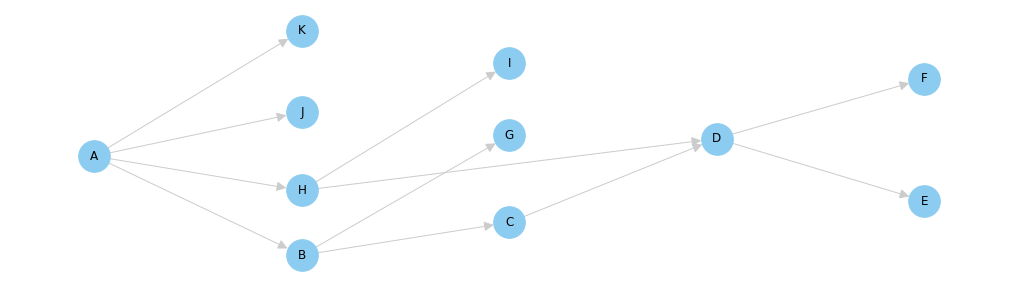

In [465]:
edges = [
    ('node_0', 'node_1'),
    ('node_0', 'node_2'),
    ('node_0', 'node_4'),
    ('node_0', 'node_11'),
    ('node_1', 'node_3'),
    ('node_1', 'node_6'),
    ('node_2', 'node_5'),
    ('node_2', 'node_10'),
    ('node_3', 'node_5'),
    ('node_5', 'node_7'),
    ('node_5', 'node_9')
]

random_graph = nx.DiGraph()
for (src, dst) in edges:
    random_graph.add_edge(src, dst)
    
random_graph.node['node_1']['cost'] = 2 # B
random_graph.node['node_2']['cost'] = 3 # H
random_graph.node['node_4']['cost'] = 1 # J
random_graph.node['node_11']['cost'] = 12 # K
pristine_graph = random_graph
    
fig, ax = plt.subplots(1, 1, figsize=(18, 5))
#random_graph = get_random_graph(12, cost_long_tail)
render_once(random_graph, ax)
ax

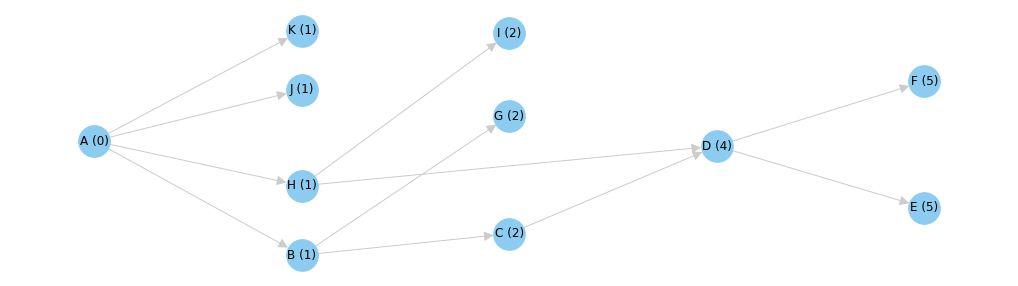

In [264]:
fig, ax = plt.subplots(1, 1, figsize=(18, 5))
render_once(pristine_graph, ax, algoClass=DepthAwareGraphTraversal)
ax

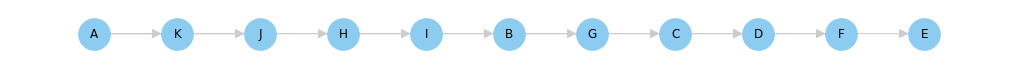

In [254]:
fig, ax = plt.subplots(1, 1, figsize=(18, 1))
render_once(pristine_graph, ax, algoClass=TopologicalSortedGraphTraversal)
ax

Traceback (most recent call last):
  File "/Users/drew/fishtown/graph-blog/env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/Users/drew/fishtown/graph-blog/env/lib/python3.7/site-packages/matplotlib/animation.py", line 999, in _start
    self._init_draw()
  File "/Users/drew/fishtown/graph-blog/env/lib/python3.7/site-packages/matplotlib/animation.py", line 1740, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
StopIteration


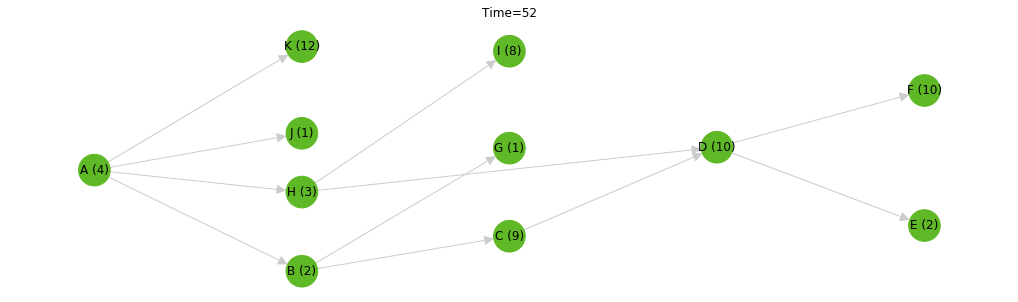

In [468]:
algos = [
    NaiveGraphTraversal
]
sim_res = render(pristine_graph, step_ms=300, algos=algos)
HTML(sim_res['animation'].to_jshtml())

Traceback (most recent call last):
  File "/Users/drew/fishtown/graph-blog/env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/Users/drew/fishtown/graph-blog/env/lib/python3.7/site-packages/matplotlib/animation.py", line 999, in _start
    self._init_draw()
  File "/Users/drew/fishtown/graph-blog/env/lib/python3.7/site-packages/matplotlib/animation.py", line 1740, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
StopIteration


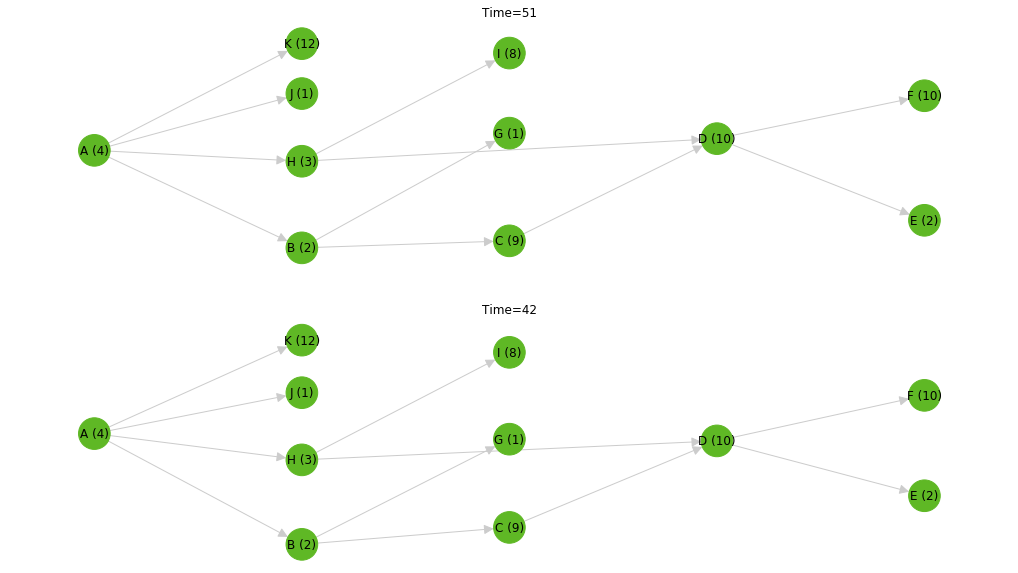

In [470]:
algos = [
    NaiveGraphTraversal,
    SmartGraphTraversal
]
sim_res = render(random_graph, step_ms=300, algos=algos)
HTML(sim_res['animation'].to_jshtml())

Traceback (most recent call last):
  File "/Users/drew/fishtown/graph-blog/env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/Users/drew/fishtown/graph-blog/env/lib/python3.7/site-packages/matplotlib/animation.py", line 999, in _start
    self._init_draw()
  File "/Users/drew/fishtown/graph-blog/env/lib/python3.7/site-packages/matplotlib/animation.py", line 1740, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
StopIteration


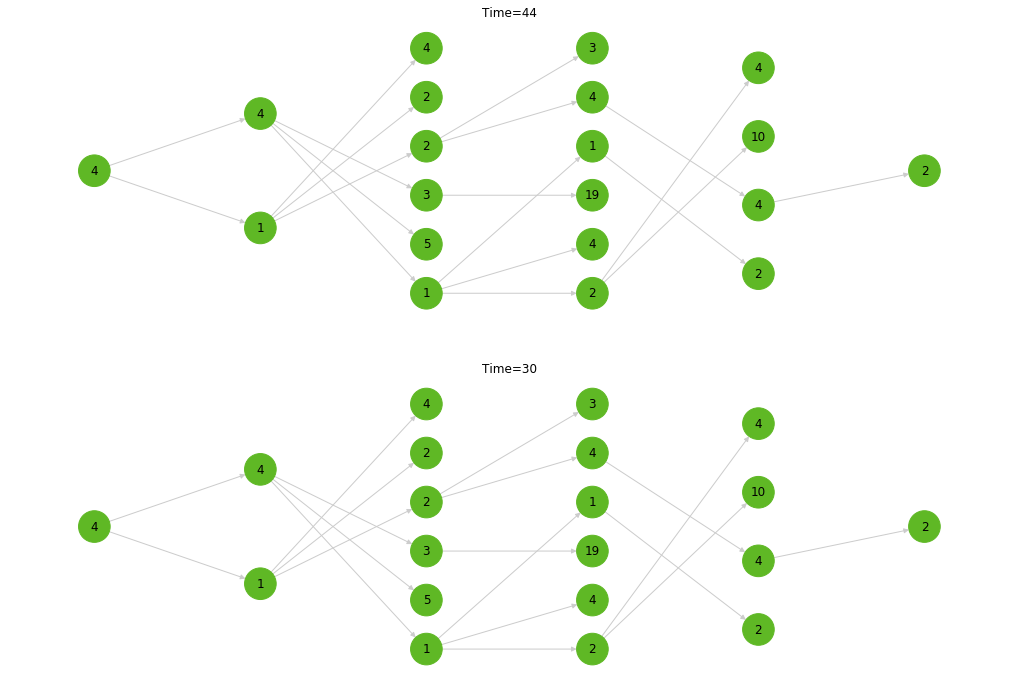

In [8]:
sim_res = render(random_graph, step_ms=300)
HTML(sim_res['animation'].to_html5_video())

In [354]:
sim_res['algos']

{'Run Level': <__main__.NaiveGraphTraversal at 0x11dc30198>,
 'Priority Queue': <__main__.SmartGraphTraversal at 0x11dc30710>}

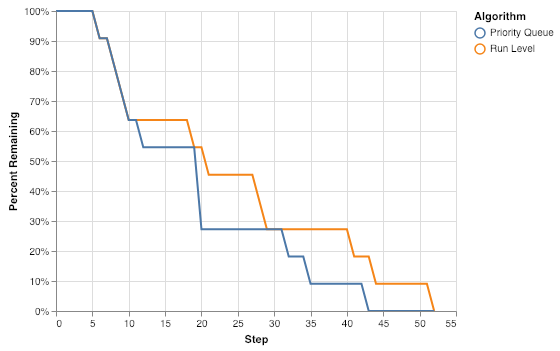

In [471]:
import pandas as pd

naive_ticks = sim_res['algos']['Run Level'].ticks
smart_ticks = sim_res['algos']['Priority Queue'].ticks

df = pd.DataFrame({"naive": naive_ticks, "smart": smart_ticks})
df['num_models'] = df.naive.max()
df['Run Level'] = 1 - (df.naive / df.num_models)
df['Priority Queue'] = 1 - (df.smart / df.num_models)
df['Step'] = df.index

source = pd.melt(
    df,
    id_vars='Step',
    value_vars=['Run Level', 'Priority Queue'],
    var_name='Algorithm',
    value_name='Percent Remaining'
)

alt.Chart(source).mark_line().encode(
    x='Step',
    y=alt.Y('Percent Remaining', axis=alt.Axis(format='%')),
    color='Algorithm'
)

In [10]:
random_graph

In [485]:
def simulate(graph):
    process(graph)
    
    graph_id = str(uuid.uuid4())

    naive_algo = NaiveGraphTraversal(graph, graph_id)
    smart_algo = SmartGraphTraversal(graph, graph_id)
    
    animation_complete = {"done": False}

    def update(i):
        done_naive = naive_algo.update(i)
        done_smart = smart_algo.update(i)
        
        if done_naive and done_smart:
            animation_complete['done'] = True
            
    def frames():
        i = 0
        while not animation_complete['done']:
            yield i
            i += 1


    for i in frames():
        update(i)
        
    return {
        "naive": naive_algo.stats(),
        "smart": smart_algo.stats()
    }

num_trials = 100
stats = []
for i in range(num_trials):
    graph_size = random.randint(10, 100)
    random_graph = get_random_graph(graph_size, cost_uniform, edge_prob=0.8, max_edges=10)
    new_stats = simulate(random_graph)
    stats.append(new_stats)

In [486]:

naive_df = pd.DataFrame([s['naive'] for s in stats])
naive_df['type'] = 'naive'

smart_df = pd.DataFrame([s['smart'] for s in stats])
smart_df['type'] = 'smart'

df = naive_df.append(smart_df)

df['avg_cost'] = df.costs.map(np.average)
df['med_cost'] = df.costs.map(np.median)
df['max_cost'] = df.costs.map(np.max)
df['cost_ratio'] = df['max_cost'] / df['med_cost']

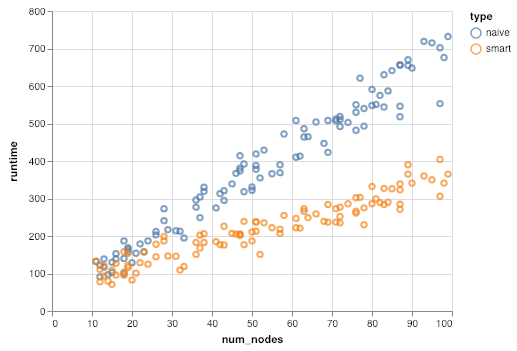

In [487]:
alt.Chart(df).mark_point().encode(
    x='num_nodes',
    y='runtime',
    color='type',
)

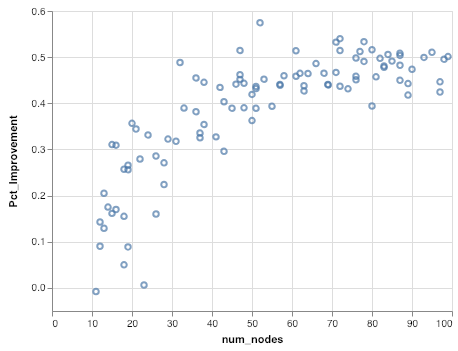

In [488]:
cmp_df = df.pivot(index='graph_id', columns='type', values='runtime')
cost_df = df[['graph_id', 'num_nodes']].drop_duplicates()
cmp_df['diff'] = cmp_df.naive - cmp_df.smart
cmp_df['Pct_Improvement'] = (cmp_df.naive - cmp_df.smart) / cmp_df.naive
cmp_df = cmp_df.merge(cost_df, on='graph_id')

alt.Chart(cmp_df).mark_point().encode(
    x='num_nodes',
    y='Pct_Improvement',
    tooltip=['graph_id', 'naive', 'smart', 'Pct_Improvement']
)

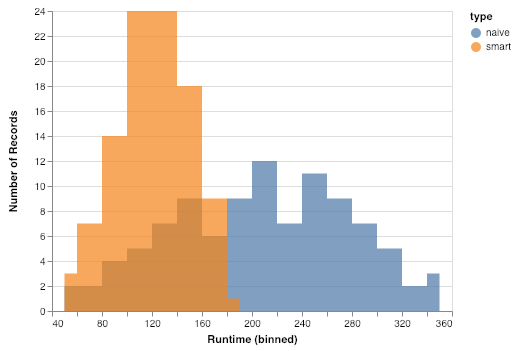

In [453]:
source = pd.melt(
    df,
    id_vars=['graph_id', 'type'],
    value_vars='runtime',
    var_name='Value',
    value_name='Runtime'
)

alt.Chart(source).mark_area(
    opacity=0.7,
    interpolate='step'
).encode(
    alt.X('Runtime', bin=alt.Bin(maxbins=25)),
    alt.Y('count()', stack=None),
    alt.Color(
        'type',
        scale=alt.Scale()
    )
)

In [381]:
cmp_df

graph_id  naive  smart  diff  Pct_Improvement  \
0   024959c1-5a03-47ce-8cbc-18dfa401edfa     74     59    15         0.202703   
1   0fcfae84-1736-45d1-b575-9b12648ba8eb    122     98    24         0.196721   
2   100aad4e-aadb-496e-b580-f3aa3dbea561    100     59    41         0.410000   
3   117544da-b88d-4383-8171-c8b8c44a5dd2    138     83    55         0.398551   
4   12eaf955-2453-4278-8ad9-c502748973f6    105     44    61         0.580952   
5   13afe1f8-f594-458c-8473-461646b54d38    172    103    69         0.401163   
6   14f4df28-c6e5-4eb3-84ec-3c09c0698ab6    108     40    68         0.629630   
7   19609acc-850c-4de5-bb3b-2e5602cdc1f8    104     55    49         0.471154   
8   1a25617e-c759-4bc7-ac01-c49d4b22fe9d    103     75    28         0.271845   
9   1da3c8e2-a716-45af-af72-73d3fefd00c1    121     66    55         0.454545   
10  230e93fa-cf9d-4b47-945e-e8e54f091a8f     57     44    13         0.228070   
11  25851ae5-cff5-4dbf-8830-95d8bb1acaad     98     66    32         0.326531   
12  29822d7b-579f-4967-92c9-530e312617a4     94     61    33         0.351064   
13  2bd851d1-1e3c-487e-8020-242558c8032c    124     81    43         0.346774   
14  2d17f52d-7df3-46b3-93ba-4adba3e01d77    123     64    59         0.479675   
15  2f2e9c02-e85e-4725-be53-ae0c638dfbbc    140     70    70         0.500000   
16  31a69e41-7e96-4dd4-a4a3-d3484e92c0eb     36     34     2         0.055556   
17  31da4a28-4237-46f9-bb5f-8bf826b07207     95     68    27         0.284211   
18  32ac7927-6d99-466b-ac3d-5fd837f9d9e4     55     34    21         0.381818   
19  352f60a1-161b-4e2e-8153-1bc5cd83a607     82     51    31         0.378049   
20  370ae7aa-cbd9-4224-af71-c29cee745a8d    133     54    79         0.593985   
21  387d019b-7552-4e33-9bc4-629a0e8f6f50     62     44    18         0.290323   
22  3aa36aa4-5ed9-40d9-8ca8-60ea0c717a4d    104     44    60         0.576923   
23  3b7100b5-7539-4777-92de-84097d4a69d0     84     44    40         0.476190   
24  3c212c56-5c11-4d2a-81c9-a4d5b06604b1     71     46    25         0.352113   
25  3d4acd1f-1136-4187-89e1-2df2105ad9d0    105     49    56         0.533333   
26  420f1c62-e5bb-4e5c-9ba4-c7eb0ac85946    125     61    64         0.512000   
27  44a8d7a2-de16-4adc-b31a-9feb76a5a2bf     82     58    24         0.292683   
28  45015b58-e9a3-4cd7-a361-e47612d67bfe     59     33    26         0.440678   
29  459c63ef-62ac-42d1-852f-ed0e36df770c     69     45    24         0.347826   
..                                   ...    ...    ...   ...              ...   
70  b309ca9f-e7c4-4ef3-b969-6c6c51cdf656     93     62    31         0.333333   
71  b57051a3-d9dc-4496-8f85-420bfb338360     35     29     6         0.171429   
72  b5b7ca2f-130e-4a2e-96de-8a8e58dbdc6d     95     43    52         0.547368   
73  bbb05141-dc56-4507-ae7d-eda79ce914f7     73     52    21         0.287671   
74  bce5c747-f50b-4764-900b-a825af3b8785    107     76    31         0.289720   
75  bfa2b810-22de-423e-bd2b-ba8dd3c1fd8e     67     49    18         0.268657   
76  c2bde4b5-4746-4aed-8530-0a947517a4ee     64     32    32         0.500000   
77  cbb4ab42-c651-4cbb-943b-a8d2e63dc5cf     48     40     8         0.166667   
78  cbd60aae-92f0-4e3a-ab71-fb91d7ae2ca9     82     61    21         0.256098   
79  ccce3dd5-1e61-4f10-bacf-416cd3fe1869     41     41     0         0.000000   
80  cf0c3ddd-07f4-4699-a788-e460d783a4d9     66     37    29         0.439394   
81  d0a7842d-1f08-4f38-9320-80e0cd20b6cf    119     65    54         0.453782   
82  d1c8d636-b41e-4817-84f0-11caa5e1be00     38     28    10         0.263158   
83  d49e76ac-c4ae-481d-946b-24c3d0e4aab4    112     65    47         0.419643   
84  d67c4718-c1e5-495f-81ae-0dfc27a9b006    134     60    74         0.552239   
85  d96a0b84-7526-4cb2-a9f7-655d83578b34     89     38    51         0.573034   
86  d9d741c6-6284-448a-9acb-1d5cd0d3e42e    108     60    48         0.444444   
87  da898ec2-f099-4274-9e27-c06cd679f78a    126     79    47   